# preprocess image

In [26]:
import os
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.svm import SVC

import imgaug as ia
import imgaug.augmenters as iaa
ia.seed(1)

import pickle

In [27]:
def crop_roi(img):
    '''
    crop img
    Args:
        img: source image
    Return:
        roi: cropped image
    '''
    DIM = 50
    OFFSET = 250
    # crop roi
    h,w,c = img.shape
    center = (int(h/2)+OFFSET,int(w/2)+OFFSET)
    top_left = (center[0]-DIM,center[1]-DIM)
    bottom_right = (center[0]+DIM,center[1]+DIM)
    roi = img[top_left[0]:bottom_right[0],top_left[1]:bottom_right[1]]
    return roi

In [28]:
path = 'egs'
if not os.path.exists(path):
    os.mkdir(path)

# EDA

reading image:  colors/sand/1.jpg


Text(0.5, 1.0, 'sand')

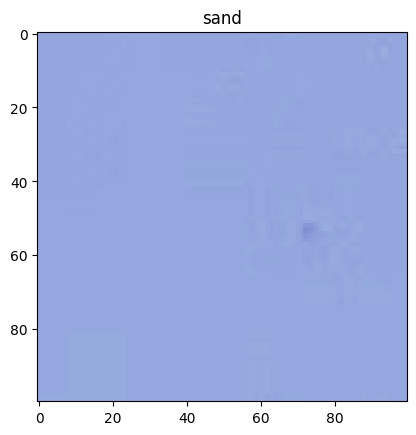

In [29]:
# read image
path2 = 'colors'
colors = os.listdir(path2)
color = random.choice(colors)
imgs = os.listdir(os.path.join(path2,color))
img = random.choice(imgs)
img = os.path.join(path2,color,img)

print('reading image: ',img)
img = cv2.imread(img)

roi = crop_roi(img)

plt.imshow(roi)
plt.title(color)

generate cropped image

In [30]:
colors = os.listdir(path2)

for c in colors:
    # create floder
    if not os.path.exists(os.path.join(path,c)):
        os.mkdir(os.path.join(path,c))
    
    # list image
    imgs =  os.listdir(os.path.join(path2,c))
    
    # crop images
    for i,im in enumerate(imgs):
        img_path = os.path.join(path2,c,im)
        img = cv2.imread(img_path)
        roi = crop_roi(img)
        name = c+str(i)+'.jpg'
        cv2.imwrite(os.path.join(path,c,name),roi)

In [31]:
colors = os.listdir(path2)

for c in colors:
    # list images
    imgs =  os.listdir(os.path.join(path2,c))
    print(f'{c}:{len(imgs)}')

sage:10
sand:11
charcoal:10
sky:12
chalk:1


# image augmentation

In [32]:
augmentation = iaa.Sequential([
    # 1. Flip
    iaa.Fliplr(0.5),
    iaa.Flipud(0.5),
    
    # 2. Linearcontrast
    iaa.LinearContrast((0.8, 1.2)),
    
    # 3. Perform methods below only sometimes
    iaa.Sometimes(0.5,
                  
    # 4. GaussianBlur
    iaa.GaussianBlur((0.0, 3.0))
    )
    ])

In [33]:
path = 'egs'
path2 = 'colors'

path3 = 'augs'
if not os.path.exists(path3):
    os.mkdir(path3)
    
colors = os.listdir(path2)
N = 500

for color in colors:
    imgs = os.listdir(os.path.join(path,color))
    m = len(imgs)
    k = N//m

    # create floder
    if not os.path.exists(os.path.join(path3,color)):
        os.mkdir(os.path.join(path3,color))

    for j,i in enumerate(imgs):
        im = cv2.imread(os.path.join(path,color,i))
        ims = np.array([ im for _ in range(k)],dtype=np.uint8)
        imaugs = augmentation(images=ims)

        for l,au in enumerate(imaugs):
            name= color+str(j)+str(l)+".jpg"
            cv2.imwrite(os.path.join(path3,color,name),au)

# prepare training data

['sage', 'sand', 'charcoal', 'sky', 'chalk']

{0: 'sage', 1: 'sand', 2: 'charcoal', 3: 'sky', 4: 'chalk'}

{'sage': 0, 'sand': 1, 'charcoal': 2, 'sky': 3, 'chalk': 4}

In [34]:
path ='augs'
labels = os.listdir(os.path.join(path))
print(labels)
dic = {}
for k,l in enumerate(labels):
    dic[k]=l
dic

['sage', 'sand', 'charcoal', 'sky', 'chalk']


{0: 'sage', 1: 'sand', 2: 'charcoal', 3: 'sky', 4: 'chalk'}

In [35]:
dic_invert = {v:k for k,v in dic.items()}
dic_invert

{'sage': 0, 'sand': 1, 'charcoal': 2, 'sky': 3, 'chalk': 4}

In [36]:
X = []
y = [] #0,1,2,3,4
for k,label in enumerate(labels):
    for i in os.listdir(os.path.join(path,label)):
        img = cv2.imread(os.path.join(path,label,i))
        X.append(img)
        y.append(k)

In [37]:
X = np.array(X).reshape(len(X),-1)
print(X.shape)
print(y[:10])

(2477, 30000)
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [38]:
# shuffle
X,y = shuffle(X,y)

In [39]:
# norm
X = X/255.0
y = np.array(y)

In [40]:
# split
X_train, X_val, y_train, y_val = train_test_split(X,y)

In [41]:
svc = SVC(kernel='linear',gamma='auto') #linear,rbf
svc.fit(X_train, y_train)

SVC(gamma='auto', kernel='linear')

In [42]:
y2 = svc.predict(X_val)

In [43]:
# calc accuracy
print("Accuracy on unknown data is",accuracy_score(y_val,y2))

Accuracy on unknown data is 1.0


In [44]:
print("Accuracy on unknown data is",classification_report(y_val,y2))

Accuracy on unknown data is               precision    recall  f1-score   support

           0       1.00      1.00      1.00       117
           1       1.00      1.00      1.00       125
           2       1.00      1.00      1.00       130
           3       1.00      1.00      1.00       121
           4       1.00      1.00      1.00       127

    accuracy                           1.00       620
   macro avg       1.00      1.00      1.00       620
weighted avg       1.00      1.00      1.00       620



In [45]:
del X_train
del y_train
del X_val
del y_val

In [46]:
# save the model to disk
filename = 'classifier_model.sav'
pickle.dump(svc, open(filename, 'wb'))

# test trained model

In [47]:
# load saved model
filename = 'classifier_model.sav'
loaded_model = pickle.load(open(filename,'rb'))

In [48]:
path = 'egs'
colors = os.listdir(path)
for color in colors:
    imgs = os.listdir(os.path.join(path,color))

    X = []
    y = []

    for i in imgs:
        img = cv2.imread(os.path.join(path,color,i))
        X.append(img)
        k = dic_invert[color]
        y.append(k)

    X = np.array(X).reshape(len(X),-1)
    X = X/255.0
    y = np.array(y)

    preds = loaded_model.predict(X)

    # calc accuracy
    print("Accuracy on ",color," data is",accuracy_score(y,preds))

Accuracy on  sage  data is 1.0
Accuracy on  sand  data is 1.0
Accuracy on  charcoal  data is 1.0
Accuracy on  sky  data is 1.0
Accuracy on  chalk  data is 1.0


# random test

reading image:  colors/chalk/1.jpg


Text(0.5, 1.0, 'pred: chalk ground truth: chalk')

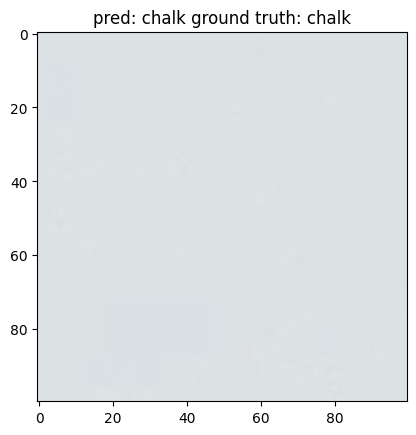

In [49]:
# read image
path = 'colors'
colors = os.listdir(path)
color = random.choice(colors)
imgs = os.listdir(os.path.join(path,color))
img = random.choice(imgs)
img = os.path.join(path,color,img)
print('reading image: ',img)
img = cv2.imread(img)
img = img/255.0

# predict
roi = crop_roi(img)
x = roi.reshape(1,-1)

y= loaded_model.predict(x)

plt.imshow(roi)
plt.title("pred: " + dic[int(y)] + " ground truth: " + color)

# predict

In [50]:
path = 'colors'
colors = os.listdir(path)

for color in colors:
    
    X = []
    y = []
    
    imgs = os.listdir(os.path.join(path,color))

    for i in imgs:
        img = cv2.imread(os.path.join(path,color,i))
        roi = crop_roi(img)
        X.append(roi)
        k = dic_invert[color]
        y.append(k)

    X = np.array(X).reshape(len(X),-1)
    X = X/255.0
    y = np.array(y)

    preds = loaded_model.predict(X)

    # calc accuracy
    print("Accuracy on ",color," data is",accuracy_score(y,preds))

Accuracy on  sage  data is 1.0
Accuracy on  sand  data is 1.0
Accuracy on  charcoal  data is 1.0
Accuracy on  sky  data is 1.0
Accuracy on  chalk  data is 1.0


test on specific floder

In [51]:
path = 'hailu'
imgs = os.listdir(path)
for i in imgs:
    img = cv2.imread(os.path.join(path,i))
    img = img/255.0
    # predict
    roi = crop_roi(img)
    x = roi.reshape(1,-1)
    y= loaded_model.predict(x)
    print("img: " + i + " pred: " + dic[int(y)])

img: BC731C2F-FEDA-4842-B04A-C6127E8977F6_1_201_a copy.jpg pred: sky
img: 8745399D-F139-4F05-873F-0F8191CA9E8E_1_201_a copy.jpg pred: sky
img: CEF4D2BF-DFFC-493B-925C-A60CE93B3CD4_1_201_a copy.jpg pred: sky
img: EF5057F0-EFA0-4302-ADA7-AE930C6D798D_1_201_a copy.jpg pred: sky
img: D18A923B-5C69-46D0-9023-E6AF26B1D481_1_201_a copy.jpg pred: sky
img: FC917109-B5C9-4C0A-85D7-89F2EF88462C_1_201_a copy.jpg pred: sky
img: DFC151B1-4787-42B3-A588-717076A4A34E_1_201_a copy.jpg pred: sky
img: D9A0B22D-8F1E-4B22-AE30-31185B62A0CC_1_201_a copy.jpg pred: sky
img: 84BCDAC7-8E70-4046-AF7B-FA73FF2EA309_1_201_a copy.jpg pred: sky
img: 36ABC165-013D-43F4-8CD6-AA550E423EE1_1_201_a copy.jpg pred: sky
img: 73BE3405-F511-4F03-8C09-03E3F241F181_1_201_a copy.jpg pred: sky
img: 4C6F0F21-4147-4467-8C58-BABF57F805AA_1_201_a copy.jpg pred: sky
img: 181A420A-8A9B-4AAF-AB9B-1A2A434FD47D_1_201_a copy.jpg pred: sky
img: 67B846AB-0D76-4690-AEA6-EA931D20F9D7_1_201_a copy.jpg pred: sky
img: DCEC0B81-E2E0-480F-8593-14C9D

Text(0.5, 1.0, 'pred: sky')

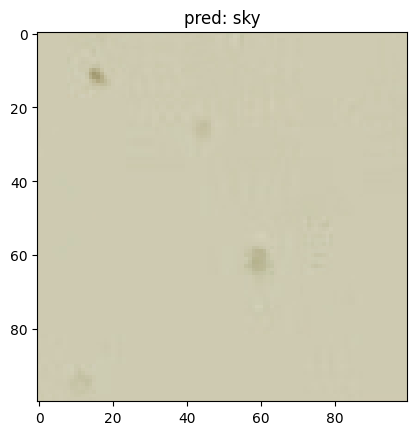

In [52]:
img_path = "hailu/36ABC165-013D-43F4-8CD6-AA550E423EE1_1_201_a copy.jpg"
img = cv2.imread(img_path)
img = img/255.0

# predict
roi = crop_roi(img)
x = roi.reshape(1,-1)

y= loaded_model.predict(x)

plt.imshow(roi)
plt.title("pred: " + dic[int(y)])